# Temporal Clustering

In [13]:
import psycopg2, multiprocessing, psycopg2.extras, os, json, sys, time, scipy
from multiprocessing import Pool, Manager 
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The `working_data` directory holds the geojsonl files of the users after the first geo-clustering

In [14]:
working_data = '../working_data/clustered_three_pts_with_speed_2/'

In [15]:
files = os.listdir(working_data)
len(files)

13672

In [16]:
def loader_function(args):
    uFile, q = args
    u = json.load(open("../working_data/clustered_three_pts_with_speed/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        t['properties']['geometry'] = shape(t['geometry'])
        t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    q.put(1)
    return gpd.GeoDataFrame(tweets)

In [17]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in files]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
users = result.get()
p.close()

Processed: 13672, 100%

In [18]:
len(users)

13672

In [19]:
#Total Number of tweets for these users
sum([len(x) for x in users])

1221800

## Number of Geographic Clusters Per User by Month
A quick analysis of Spatial Cluster Numbers

In [20]:
distinct_clusters_september       = []
distinct_clusters_october         = []
distinct_clusters_november        = []
number_of_tweets                  = []
for idx, u in enumerate(sorted(users, key=lambda u: len(u),reverse=True)):
    distinct_clusters_september.append(  len(u.query('date < 201210010000').cluster.value_counts()) )
    distinct_clusters_october.append(    len(u.query('date >= 201210010000 and date < 201211010000').cluster.value_counts()) )
    distinct_clusters_november.append(   len(u.query('date >= 201211010000').cluster.value_counts()) )
    number_of_tweets.append(len(u))
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))
monthly_counts = pd.DataFrame({  "september" : distinct_clusters_september, 
                                 "october"   : distinct_clusters_october, 
                                 "november"  : distinct_clusters_november,
                                 "t_count"   : number_of_tweets } )

13670

In [21]:
monthly_counts.sort_values('t_count', inplace=True)
monthly_counts.head()

,november,october,september,t_count
13671,0,0,1,3
13641,0,0,1,3
13640,0,1,0,3
13639,0,0,1,3
13638,0,1,0,3


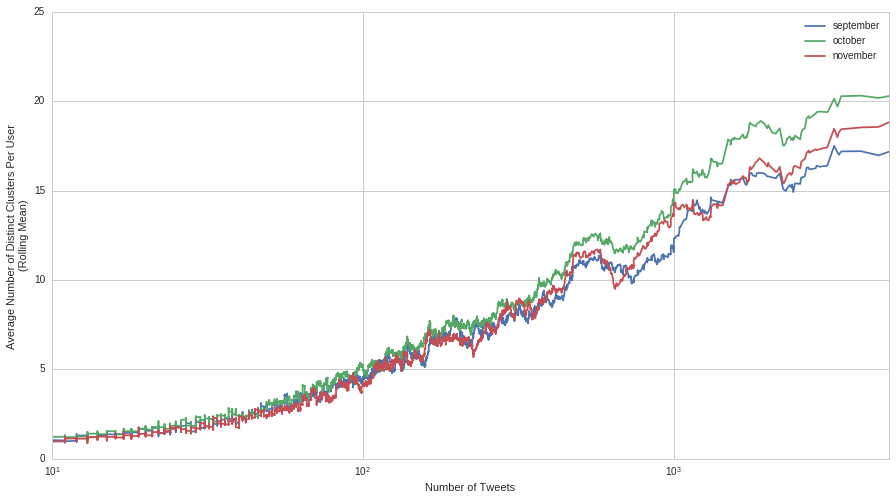

In [22]:
sns.set_style('whitegrid')
ax = monthly_counts[['september','october','november']].rolling(100).mean().plot(x=monthly_counts.t_count)
ax.figure.set_size_inches(15,8)
ax.set_xlim(10,4934)
ax.set_xscale('log')
ax.set_ylabel("Average Number of Distinct Clusters Per User \n(Rolling Mean)")
ax.set_xlabel("Number of Tweets")

In [23]:
monthly_counts.median()

november      2.0
october       2.0
september     2.0
t_count      36.0
dtype: float64

In [24]:
print(scipy.stats.mstats.kruskalwallis(monthly_counts['september'], monthly_counts['october']))
print(scipy.stats.mstats.kruskalwallis(monthly_counts['october'], monthly_counts['november']))
print(scipy.stats.mstats.kruskalwallis(monthly_counts['september'], monthly_counts['november']))

print(scipy.stats.mstats.kruskalwallis(monthly_counts['september'], monthly_counts['october'], monthly_counts['november']))

KruskalResult(statistic=96.974093804983696, pvalue=7.024037184494436e-23)
KruskalResult(statistic=169.74508713557097, pvalue=8.4108955269416975e-39)
KruskalResult(statistic=9.6220199891192255, pvalue=0.001922581540623147)
KruskalResult(statistic=184.3456896110913, pvalue=9.3291509372707936e-41)


# When were these tweets? 
Overall, do we see a spike at Landfall?

In [25]:
len(users)

13672

In [26]:
timestamps  = pd.Series()
user_series = pd.Series()
for idx, u in enumerate(users):
    timestamps  = timestamps.append(u.date)
    user_series = user_series.append(u.user)
    if idx%5==0:
        sys.stderr.write("\r"+str(idx))

13670

In [27]:
df = pd.DataFrame({"full_date":timestamps, "user":user_series})
df['date'] = df.full_date.dt.date
df.sort_values('full_date', inplace=True)
gb_date = df.groupby('date')

In [28]:
sorted_user_counts = gb_date.agg({'user':pd.Series.nunique}).sort_index()

In [29]:
sorted_counts = df['date'].value_counts(sort=False).sort_index() #Dates sorted...

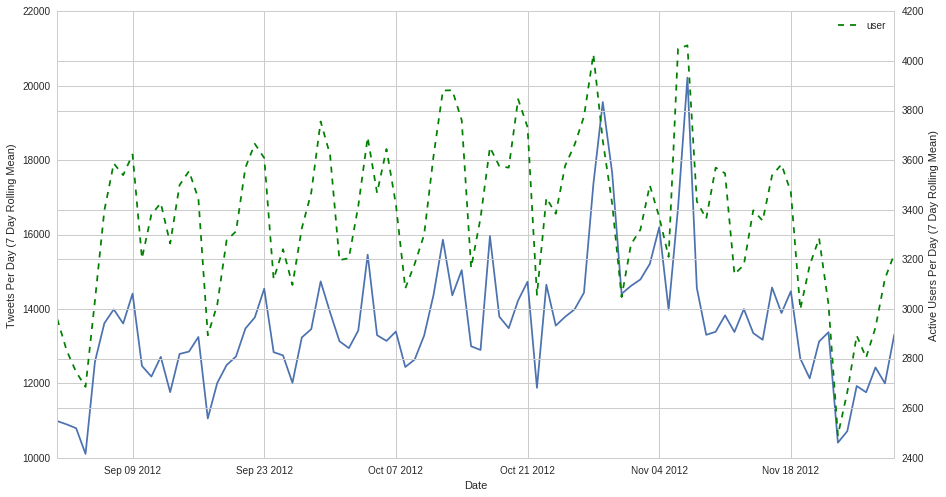

In [30]:
# ax = sorted_counts.rolling(7).mean().plot(label="tweets")
ax = sorted_counts.plot(label="tweets")
ax2 = ax.twinx()
# sorted_user_counts.rolling(7).mean().plot(ax=ax2, color='green', ls='--')
sorted_user_counts.plot(ax=ax2, color='green', ls='--')
ax.figure.set_size_inches(15,8)
ax.set_ylabel("Tweets Per Day (7 Day Rolling Mean)")
ax2.set_ylabel("Active Users Per Day (7 Day Rolling Mean)")
ax.set_xlabel("Date")

# Identifying Temporal Clusters
Use a custom _worker_ function to find specific time clusters

## Filter Level 1: Enough Tweets?

Ensure that we have the following for each user:
1. Geo-Cluter Information (If no geo-clusters are available, remove)
2. Enough Tweets (At least *A* Tweet during the storm)

In [31]:
_landfall_str = '201210300000'
_start_str    = '201210290000'
_end_str      = '201210310000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

In [32]:
def time_cluster(t):
    t = t.tz_convert("EST")
    '''Get the timecluster'''
    hour = t.hour//4 + 1
    if t.weekday()>4:
        return 6+hour
    else:
        return hour
    
def worker_function(args):
    userDF, q = args
    
    #If no tweets around the time of the storm, then fail.
    if len(userDF.query("date > %s & date < %s"%(_start_str, _end_str))) < 1:
        q.put(1)
        return None
    
    userDF['day_cluster'] = userDF.date.apply(lambda t: time_cluster(t))
    q.put(0)
    return userDF

In [33]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(worker_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)

values = result.get()
x = [i for i in values  if i is not None]
nones = [i for i in values  if i is None]
p.close()

Processed: 13672, 100%

In [34]:
len(users), len(nones), len(x)

(13672, 8813, 4859)

In [35]:
_users = sorted(x, key=lambda y: len(y), reverse=True)

## Explore the Correlations & Diurnal Distributions

In [36]:
corrs = np.array([u.corr()['cluster']['day_cluster'] for u in _users])
_corrs = sorted(corrs[~np.isnan(corrs)], reverse=True)

In [37]:
len(corrs), len(_corrs)

(4859, 4843)

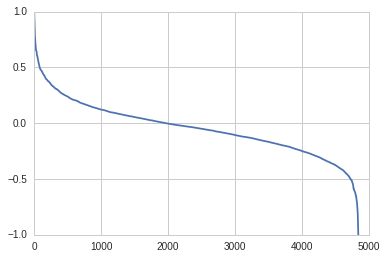

In [38]:
fig, ax = plt.subplots(1)
ax.plot(_corrs)

In [39]:
_usersDF = pd.DataFrame()
for idx, u in enumerate(_users):
    _usersDF = _usersDF.append(pd.DataFrame(u[['date','user','day_cluster']]))
    sys.stderr.write("\r{0} of {1}".format(idx,len(_users)))
print("Tweets: ",len(_usersDF))
_usersDF.head()

4857 of 4859

Tweets:  751725


4858 of 4859

,date,user,day_cluster
0,2012-09-04 00:21:21+00:00,Andrewthemark,5
1,2012-09-04 00:22:43+00:00,Andrewthemark,5
2,2012-09-04 00:22:57+00:00,Andrewthemark,5
3,2012-09-04 00:24:06+00:00,Andrewthemark,5
4,2012-09-04 00:27:03+00:00,Andrewthemark,5


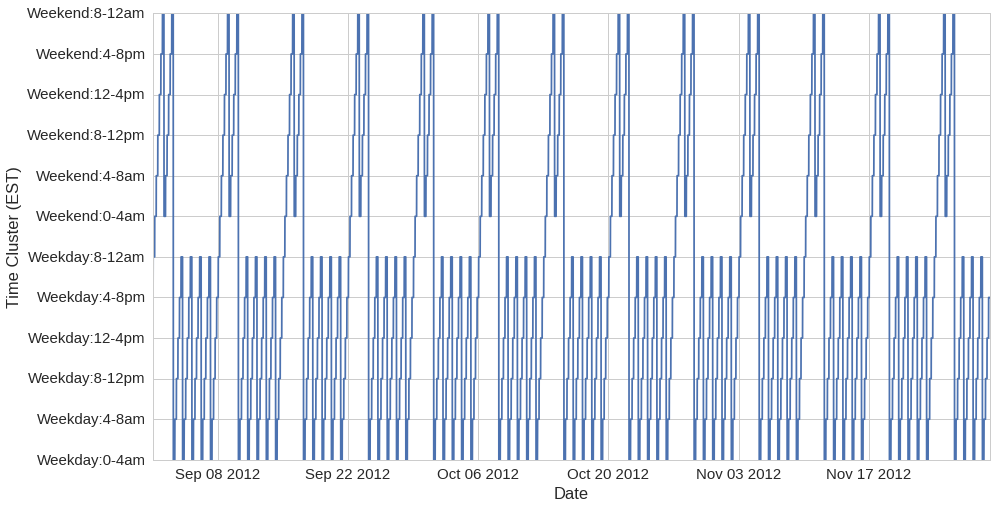

In [40]:
sns.set(font_scale=1.5); sns.set_style('whitegrid')
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)

_sorted = _usersDF.sort_values('date')

smoothed_day = _sorted['day_cluster']

ax.plot(_sorted.date, smoothed_day)

# ax.scatter(x=list(_sorted.date), y=list(smoothed_day))

ax.set_xlabel("Date")
ax.set_ylabel("Time Cluster (EST)")
ax.set_ylim(1,12)
ax.set_yticks(np.arange(1,13))
ax.set_yticklabels([
    'Weekday:0-4am','Weekday:4-8am','Weekday:8-12pm','Weekday:12-4pm','Weekday:4-8pm','Weekday:8-12am',
    'Weekend:0-4am','Weekend:4-8am','Weekend:8-12pm','Weekend:12-4pm','Weekend:4-8pm','Weekend:8-12am'
    ])
None

## Cluster counts for just the filtered users

In [41]:
_users_distinct_clusters_september       = []
_users_distinct_clusters_october         = []
_users_distinct_clusters_november        = []
_users_number_of_tweets                  = []

for idx, u in enumerate(_users):
    _users_distinct_clusters_september.append(  len(u.query('date < 201210010000').cluster.value_counts()) )
    _users_distinct_clusters_october.append(    len(u.query('date >= 201210010000 and date < 201211010000').cluster.value_counts()) )
    _users_distinct_clusters_november.append(   len(u.query('date >= 201211010000').cluster.value_counts()) )
    _users_number_of_tweets.append(len(u))
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))

4850

In [42]:
_users_monthly_counts = pd.DataFrame({   "september" : _users_distinct_clusters_september, 
                                         "october"   : _users_distinct_clusters_october, 
                                         "november"  : _users_distinct_clusters_november,
                                         "t_count"   : _users_number_of_tweets } )

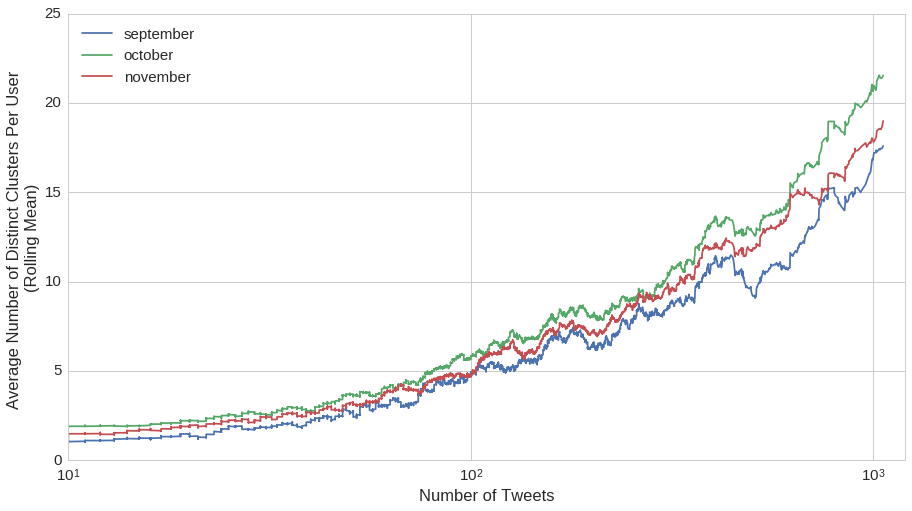

In [43]:
# ax = _users_monthly_counts.rolling(100).mean().plot()
# ax.figure.set_size_inches(15,8)
# ax.set_ylabel("Average Number of Distinct Clusters Per User \n(Rolling Mean)")
# ax.set_xlabel("Individual Users")

sns.set_style('whitegrid')
ax = _users_monthly_counts[['september','october','november']].rolling(100).mean().plot(x=_users_monthly_counts.t_count)
ax.figure.set_size_inches(15,8)
ax.set_xlim(10,1200)
ax.set_xscale('log')
ax.set_ylabel("Average Number of Distinct Clusters Per User \n(Rolling Mean)")
ax.set_xlabel("Number of Tweets")

In [44]:
_users_monthly_counts.mean()

november       4.892365
october        5.449475
september      4.287508
t_count      154.707759
dtype: float64

In [45]:
print(scipy.stats.mstats.kruskalwallis(_users_monthly_counts['september'], _users_monthly_counts['october']))
print(scipy.stats.mstats.kruskalwallis(_users_monthly_counts['october'], _users_monthly_counts['november']))
print(scipy.stats.mstats.kruskalwallis(_users_monthly_counts['september'], _users_monthly_counts['november']))

print(scipy.stats.mstats.kruskalwallis(_users_monthly_counts['september'], _users_monthly_counts['october'], _users_monthly_counts['november']))

KruskalResult(statistic=385.60201920898675, pvalue=7.5047593232611939e-86)
KruskalResult(statistic=69.267192560192854, pvalue=8.5988093486919526e-17)
KruskalResult(statistic=143.71104004944357, pvalue=4.1093015009100329e-33)
KruskalResult(statistic=399.07946083978442, pvalue=2.1927855376180008e-87)


## Investigate the Temporal Clustering of the most prolific users

In [46]:
_usersDF = pd.DataFrame()
for idx, U in enumerate(_users):
    _usersDF = _usersDF.append(pd.DataFrame(U[['date','day_cluster','user']]))
    sys.stderr.write("\r{0} of {1}".format(idx,len(_users)))

4858 of 4859

In [47]:
len(_usersDF)

751725

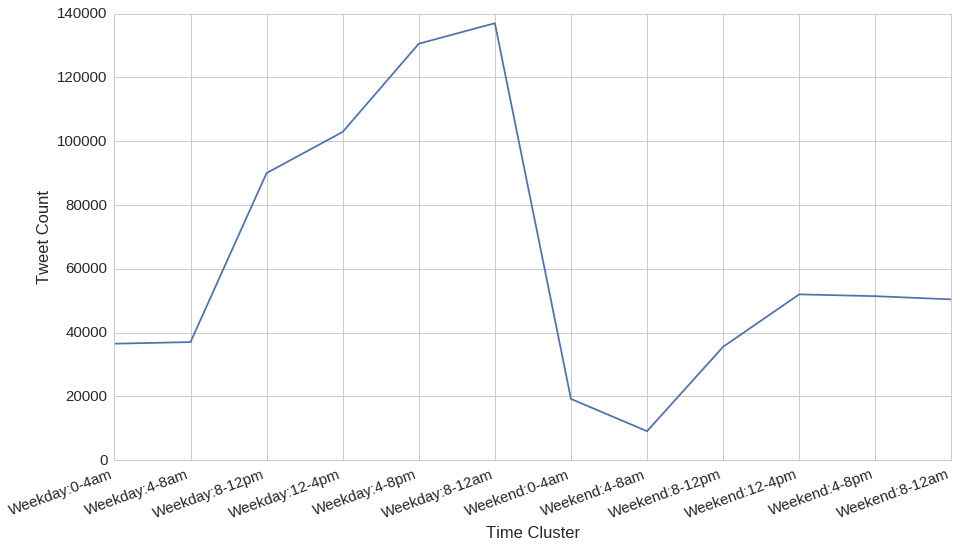

In [48]:
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)
_usersDF.day_cluster.value_counts().sort_index().plot(ax=ax)
ax.set_xticks(range(1,13))
ax.set_xticklabels([
    'Weekday:0-4am','Weekday:4-8am','Weekday:8-12pm','Weekday:12-4pm','Weekday:4-8pm','Weekday:8-12am',
    'Weekend:0-4am','Weekend:4-8am','Weekend:8-12pm','Weekend:12-4pm','Weekend:4-8pm','Weekend:8-12am'
    ], rotation=20,  ha="right")
ax.set_ylabel("Tweet Count")
ax.set_xlabel("Time Cluster")

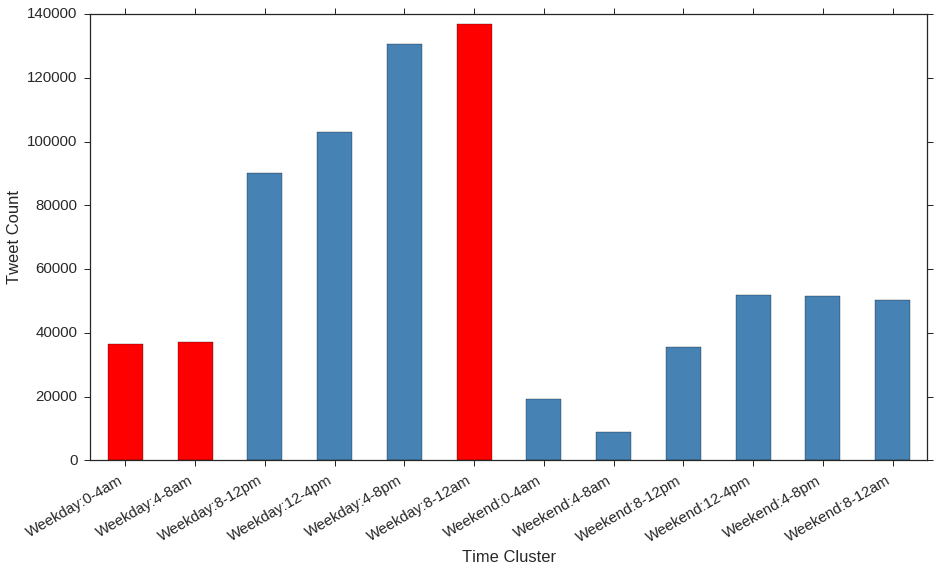

In [49]:
sns.set_style('ticks')
sns.despine()

fig, ax = plt.subplots(1); fig.set_size_inches(15,8)

_usersDF.day_cluster.value_counts().sort_index().plot(kind='bar', align='center', ax=ax, color=
['red','red','steelblue','steelblue','steelblue','red','steelblue','steelblue','steelblue','steelblue','steelblue','steelblue'])

ax.set_xticklabels([
    'Weekday:0-4am','Weekday:4-8am','Weekday:8-12pm','Weekday:12-4pm','Weekday:4-8pm','Weekday:8-12am',
    'Weekend:0-4am','Weekend:4-8am','Weekend:8-12pm','Weekend:12-4pm','Weekend:4-8pm','Weekend:8-12am'
    ], rotation=30,  ha="right")
ax.set_ylabel("Tweet Count")
ax.set_xlabel("Time Cluster")

## Group the clusters and find which geo-clusters correspond with home hours

In [50]:
from collections import Counter

In [55]:
def rank_clusters(df):
    gb_geo = df.query('date < 201210290000').groupby('cluster')
    if len(gb_geo) < 1:
        return None
    _agged = gb_geo['day_cluster'].agg({"tweets":pd.Series.count,
                                        "Number Unique Times":pd.Series.nunique,
                                        "day_cluster_counts": lambda t: Counter(t),
                                        "HomeTimes": lambda t: any(t==1) or any(t==2) or any(t==6),
                                      }).sort_values('Number Unique Times', ascending=False)
    hc = None
#   If the highest rated cluster (unique timewise includes HomeTimes, then return that)
    if(_agged.HomeTimes.values[0]):
        hc = _agged.iloc[0].name
#     return _agged
    return hc

In [60]:
# Test it with _users[100]
U = _users[100]
hc = rank_clusters(U)
print(hc)
_users[100].head(1)

4


,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,day_cluster
0,1,"[-74.01399389, 40.70330583]",2012-10-19 15:12:49+00:00,NaN,POINT (-74.01399388999999 40.70330583),NaN,@CaleOng 💋💋💋💋💋💋💋,NaN,EffinwitESH,3


In [58]:
vals= []
len_users = len(_users)
for idx, U in enumerate(_users):
    vals.append( rank_clusters(U) )
    sys.stderr.write("\r{0} of {1}".format(idx, len_users))
series = pd.Series(vals)

4858 of 4859

In [61]:
print("Clustered: {0}, Failed: {1}".format( len(series[~np.isnan(series)]),
                                            len(series[ np.isnan(series)]) ))

Clustered: 4059, Failed: 800


# User MetaData DataFrame

In [62]:
user_collection = []
for U in _users:
    user_collection.append({
            'user':U['user'].values[0],
            'tweets':len(U)
        })
_user_meta = pd.DataFrame(user_collection)

In [63]:
_user_meta['HomeCluster'] = series

In [71]:
#Test it...
_user_meta.iloc[4000]

tweets                   25
user           brokeandchic
HomeCluster             NaN
Name: 4000, dtype: object

Export the `_user_meta` dataframe

In [65]:
#Export the User Meta Dataframe...
with open('../working_data/temporal_clustered_user_meta.json','w') as metaOut:
    metaOut.write(_user_meta.to_json())

## Write these users to disk

In [66]:
os.mkdir('../working_data/spatiotemporal_clustered_stage2/')

In [72]:
_users[4000].head(3)

,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,day_cluster
0,1,"[-73.98230977, 40.72328448]",2012-10-27 12:44:03+00:00,NaN,POINT (-73.98230977 40.72328448),NaN,@Jruis the best way to spend it!,NaN,brokeandchic,8
1,1,"[-73.98230977, 40.72328448]",2012-10-27 12:45:08+00:00,0.0,POINT (-73.98230977 40.72328448),0.0,"Jealous!!! ""@logantracey: good morning! (@ Gan...",65.0,brokeandchic,8
2,1,"[-73.98230977, 40.72328448]",2012-10-27 12:45:51+00:00,0.0,POINT (-73.98230977 40.72328448),0.0,I hope you have a blast in Paris @MidtownGirl!,43.0,brokeandchic,8


In [68]:
import datetime

def safe_json_export(df):
    path = '../working_data/spatiotemporal_clustered_stage2/'
    df = df.copy()
    df['date'] = df['date'].apply(lambda t: datetime.datetime.strftime(t,'%Y-%m-%dT%H:%M:%SZ'))
#     df['time_delta'] = df['time_delta'] / np.timedelta64(1, 's')
    uName = df.head(1).user.values[0].lower()
    with open(path+uName+'.geojson','w') as oFile:
        oFile.write(df.to_json(ensure_ascii=False))

pool = Pool(24)
for i, _ in enumerate(pool.imap_unordered(safe_json_export, _users), 1):
    sys.stderr.write('\rdone {0:%}'.format(i/len(_users)))
pool.close()
pool.join()

done 100.000000%

## Calculate centroids of all user clusters -- moving to geovulnerability

In [ ]:
u = _users_with_centroids[100]

In [ ]:
_u_clusters = u.cluster_center.unique()

In [ ]:
feats = [{"type":"Feature","properties":{},"geometry":shapely.geometry.geo.mapping(p)} for p in _u_clusters]

In [ ]:
with open('EffinwitESH_clusters.json','w') as oFile:
    oFile.write(json.dumps({"type":"FeatureCollection","features":feats}))

In [ ]:
from bson import json_util

In [ ]:
f = u.query("date < 20121025000000")

In [ ]:
x = np.array(_users[100].cluster)
np.isnan(x)
np.count_nonzero(~np.isnan(x))

In [ ]:
with open('EffinwitESH.json','w') as oFile:
    oFile.write(f[['cluster', 'coords','date','geometry','speed','text','time_delta','user','day_cluster']].to_json(default=json_util.default))

In [ ]:
len(_users)

In [ ]:
_users[0].head(1)